In [2]:
import pandas as pd
import numpy as np
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import sys
from pathlib import Path

project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

# import my own modules
from commonfunc.db_handler import DbHandler

# using absolute db path
db_file = os.path.join(project_dir, "data\crypto.db") 
db = DbHandler(db_file)

crypto = 'BTC'
crypto_lower = 'btc'

In [9]:
# query price data
query = f"SELECT * FROM {crypto_lower}_hourly order by time" # contains hourly data from 2021
df = db.read_from_db(query)

# convert dt columns types to datetime
df['utc_dt'] = pd.to_datetime(df['utc_dt'])
df['nyc_dt'] = df['utc_dt'].apply(lambda x: x.astimezone(ZoneInfo("America/New_York")))

df['year'] = df['utc_dt'].dt.year
df['month'] = df['utc_dt'].dt.month
df['day'] = df['utc_dt'].dt.day
df['weekday'] = df['utc_dt'].dt.weekday # Monday=0, Sunday=6
df['hour'] = df['utc_dt'].dt.hour

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91193 entries, 0 to 91192
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype                           
---  ------      --------------  -----                           
 0   time        91193 non-null  int64                           
 1   utc_dt      91193 non-null  datetime64[ns, UTC]             
 2   nyc_dt      91193 non-null  datetime64[ns, America/New_York]
 3   high        91193 non-null  float64                         
 4   low         91193 non-null  float64                         
 5   open        91193 non-null  float64                         
 6   close       91193 non-null  float64                         
 7   volumefrom  91193 non-null  float64                         
 8   volumeto    91193 non-null  float64                         
 9   avg         91193 non-null  float64                         
 10  year        91193 non-null  int64                           
 11  month       91193 non-null  

#### Time Series Models
##### 1. ARIMA: Best when BTC prices have trend but no clear seasonality.

In [24]:
# Prepare data
tsdf = df[df['utc_dt']>='2025-02-04']
tsdf = tsdf.set_index('utc_dt')
tsdf = tsdf.sort_index()
ts = tsdf['close']

d:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
d:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
d:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
d:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-in

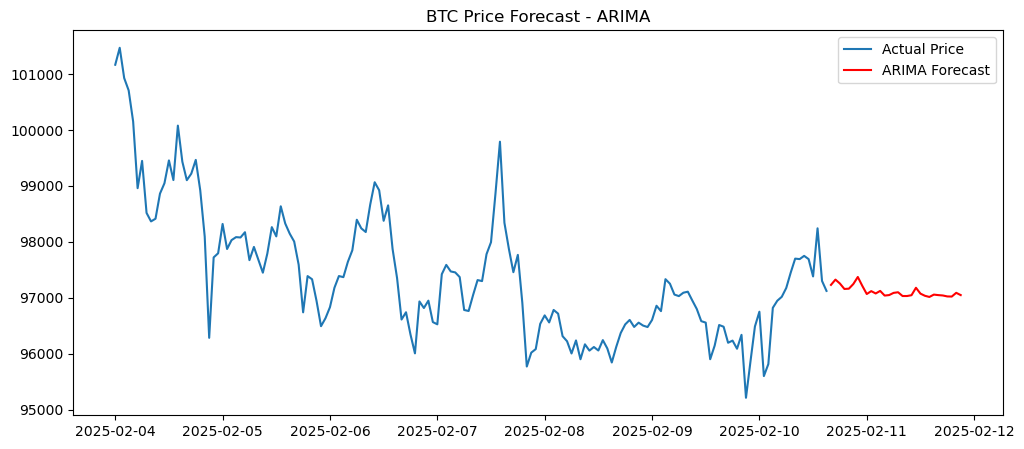

In [25]:
from statsmodels.tsa.arima.model import ARIMA

""" 
ARIMA models data as a combination of:
- AR (Auto-Regressive) → past values influence future values.
- I (Integrated) → differencing to remove trends.
- MA (Moving Average) → past forecast errors influence future values.
"""

# Fit ARIMA Model (order needs tuning)
arima_model = ARIMA(ts, order=(24,1,12))  # AR(2), I(1), MA(2)
arima_result = arima_model.fit()

# Forecast next 30 periods
arima_forecast = arima_result.forecast(steps=30)

# Plot ARIMA Forecast
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Actual Price')
plt.plot(arima_forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title("BTC Price Forecast - ARIMA")
plt.show()

##### 2. SARIMA: Best when → BTC prices show seasonal patterns (e.g., price movements based on trading hours or weekdays).

d:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
d:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


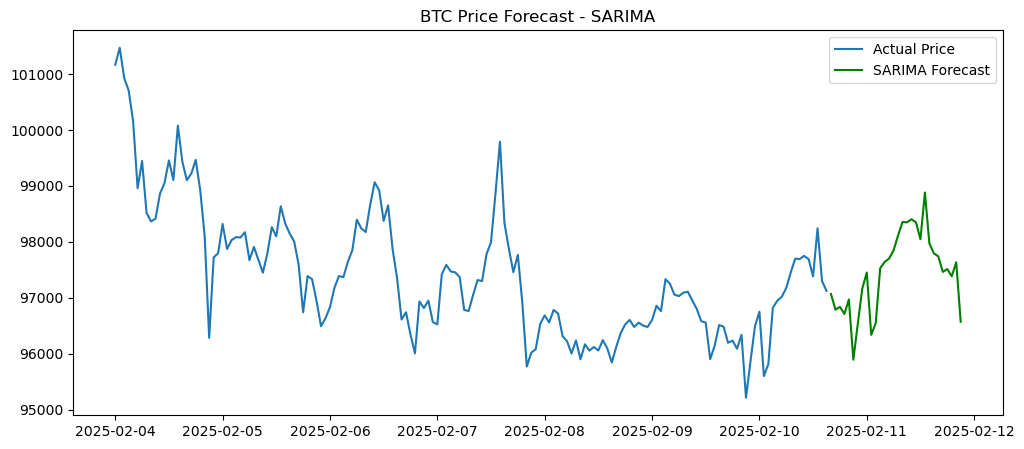

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA Model (order & seasonal_order needs tuning)
sarima_model = SARIMAX(ts, order=(2,1,2), seasonal_order=(1,1,1,24))  # 24-hour seasonality
sarima_result = sarima_model.fit()

# Forecast next 30 periods
sarima_forecast = sarima_result.forecast(steps=30)

# Plot SARIMA Forecast
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Actual Price')
plt.plot(sarima_forecast, label='SARIMA Forecast', color='green')
plt.legend()
plt.title("BTC Price Forecast - SARIMA")
plt.show()


##### 3. Prophet: Best when → BTC price has complex seasonality and external factors.

11:25:29 - cmdstanpy - INFO - Chain [1] start processing
11:25:30 - cmdstanpy - INFO - Chain [1] done processing


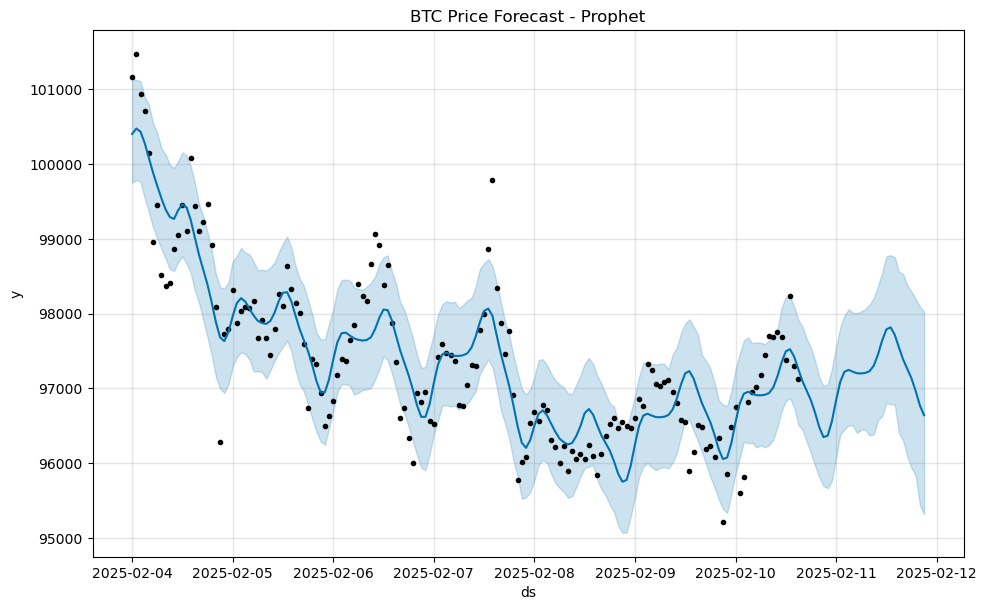

In [30]:
from prophet import Prophet

# Prepare Data for Prophet
df_prophet = tsdf[['close']].reset_index()
df_prophet.rename(columns={'utc_dt': 'ds', 'close': 'y'}, inplace=True)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)

# Fit Prophet Model
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Forecast next 30 periods
future = prophet_model.make_future_dataframe(periods=30, freq='H')  # Forecast for 30 hours
forecast = prophet_model.predict(future)

# Plot Prophet Forecast
prophet_model.plot(forecast)
plt.title("BTC Price Forecast - Prophet")
plt.show()


#### Detect Patterns
##### 1. K-Means

In [47]:
# prepare data
def create_lag_features(df, window=24):
    feature_data = []
    timestamp = []

    for i in range(window, len(df)):
        feature_data.append(df['close'].iloc[i-window : i+1].values)
        timestamp.append(df['utc_dt'].iloc[i])
    
    feature_df = pd.DataFrame(feature_data)
    feature_df['ts'] = timestamp

    return feature_df

km_df = df[df['year']>=2024]
km_df = km_df.sort_values(by='utc_dt')

# print(feature_df.head())

feature_df = create_lag_features(km_df, window=24)

X = feature_df.drop(columns=['ts'], axis=1)
X.tail(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
9726,97028.69,97089.30,97107.63,96950.30,96798.60,96580.76,96554.53,95899.94,96143.41,96512.09,96481.15,96194.38,96232.84,96087.36,96336.14,95210.48,95857.34,96485.60,96749.73,95598.45,95813.56,96819.29,96945.82,97016.23,97173.89
9727,97089.30,97107.63,96950.30,96798.60,96580.76,96554.53,95899.94,96143.41,96512.09,96481.15,96194.38,96232.84,96087.36,96336.14,95210.48,95857.34,96485.60,96749.73,95598.45,95813.56,96819.29,96945.82,97016.23,97173.89,97449.05
9728,97107.63,96950.30,96798.60,96580.76,96554.53,95899.94,96143.41,96512.09,96481.15,96194.38,96232.84,96087.36,96336.14,95210.48,95857.34,96485.60,96749.73,95598.45,95813.56,96819.29,96945.82,97016.23,97173.89,97449.05,97699.04
9729,96950.30,96798.60,96580.76,96554.53,95899.94,96143.41,96512.09,96481.15,96194.38,96232.84,96087.36,96336.14,95210.48,95857.34,96485.60,96749.73,95598.45,95813.56,96819.29,96945.82,97016.23,97173.89,97449.05,97699.04,97690.40
9730,96798.60,96580.76,96554.53,95899.94,96143.41,96512.09,96481.15,96194.38,96232.84,96087.36,96336.14,95210.48,95857.34,96485.60,96749.73,95598.45,95813.56,96819.29,96945.82,97016.23,97173.89,97449.05,97699.04,97690.40,97748.11
9731,96580.76,96554.53,95899.94,96143.41,96512.09,96481.15,96194.38,96232.84,96087.36,96336.14,95210.48,95857.34,96485.60,96749.73,95598.45,95813.56,96819.29,96945.82,97016.23,97173.89,97449.05,97699.04,97690.40,97748.11,97690.61
9732,96554.53,95899.94,96143.41,96512.09,96481.15,96194.38,96232.84,96087.36,96336.14,95210.48,95857.34,96485.60,96749.73,95598.45,95813.56,96819.29,96945.82,97016.23,97173.89,97449.05,97699.04,97690.40,97748.11,97690.61,97380.20
9733,95899.94,96143.41,96512.09,96481.15,96194.38,96232.84,96087.36,96336.14,95210.48,95857.34,96485.60,96749.73,95598.45,95813.56,96819.29,96945.82,97016.23,97173.89,97449.05,97699.04,97690.40,97748.11,97690.61,97380.20,98240.86
9734,96143.41,96512.09,96481.15,96194.38,96232.84,96087.36,96336.14,95210.48,95857.34,96485.60,96749.73,95598.45,95813.56,96819.29,96945.82,97016.23,97173.89,97449.05,97699.04,97690.40,97748.11,97690.61,97380.20,98240.86,97299.75
9735,96512.09,96481.15,96194.38,96232.84,96087.36,96336.14,95210.48,95857.34,96485.60,96749.73,95598.45,95813.56,96819.29,96945.82,97016.23,97173.89,97449.05,97699.04,97690.40,97748.11,97690.61,97380.20,98240.86,97299.75,97121.81


In [48]:
X = X.div(X.iloc[:,0], axis=0)
X.tail(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
9726,1.0,1.000625,1.000814,0.999192,0.997629,0.995384,0.995113,0.988367,0.990876,0.994676,0.994357,0.991401,0.991798,0.990298,0.992862,0.981261,0.987928,0.994403,0.997125,0.985260,0.987477,0.997842,0.999146,0.999872,1.001496
9727,1.0,1.000189,0.998568,0.997006,0.994762,0.994492,0.987750,0.990258,0.994055,0.993736,0.990783,0.991179,0.989680,0.992243,0.980649,0.987311,0.993782,0.996502,0.984645,0.986860,0.997219,0.998522,0.999247,1.000871,1.003705
9728,1.0,0.998380,0.996818,0.994574,0.994304,0.987563,0.990071,0.993867,0.993549,0.990595,0.990992,0.989493,0.992055,0.980463,0.987125,0.993594,0.996314,0.984459,0.986674,0.997031,0.998334,0.999059,1.000682,1.003516,1.006090
9729,1.0,0.998435,0.996188,0.995918,0.989166,0.991677,0.995480,0.995161,0.992203,0.992600,0.991099,0.993665,0.982055,0.988727,0.995207,0.997931,0.986056,0.988275,0.998649,0.999954,1.000680,1.002306,1.005144,1.007723,1.007634
9730,1.0,0.997750,0.997479,0.990716,0.993231,0.997040,0.996721,0.993758,0.994155,0.992652,0.995222,0.983594,0.990276,0.996766,0.999495,0.987602,0.989824,1.000214,1.001521,1.002248,1.003877,1.006720,1.009302,1.009213,1.009809
9731,1.0,0.999728,0.992951,0.995472,0.999289,0.998969,0.995999,0.996398,0.994891,0.997467,0.985812,0.992510,0.999015,1.001750,0.989829,0.992056,1.002470,1.003780,1.004509,1.006141,1.008990,1.011579,1.011489,1.012087,1.011491
9732,1.0,0.993221,0.995742,0.999560,0.999240,0.996270,0.996668,0.995162,0.997738,0.986080,0.992779,0.999286,1.002022,0.990098,0.992326,1.002742,1.004053,1.004782,1.006415,1.009264,1.011854,1.011764,1.012362,1.011766,1.008551
9733,1.0,1.002539,1.006383,1.006061,1.003070,1.003471,1.001954,1.004548,0.992811,0.999556,1.006107,1.008861,0.996856,0.999099,1.009587,1.010906,1.011640,1.013284,1.016153,1.018760,1.018670,1.019272,1.018672,1.015435,1.024410
9734,1.0,1.003835,1.003513,1.000530,1.000930,0.999417,1.002005,0.990296,0.997025,1.003559,1.006306,0.994332,0.996569,1.007030,1.008346,1.009078,1.010718,1.013580,1.016180,1.016090,1.016691,1.016093,1.012864,1.021816,1.012027
9735,1.0,0.999679,0.996708,0.997107,0.995599,0.998177,0.986514,0.993216,0.999726,1.002462,0.990533,0.992762,1.003183,1.004494,1.005224,1.006857,1.009708,1.012298,1.012209,1.012807,1.012211,1.008995,1.017912,1.008161,1.006318


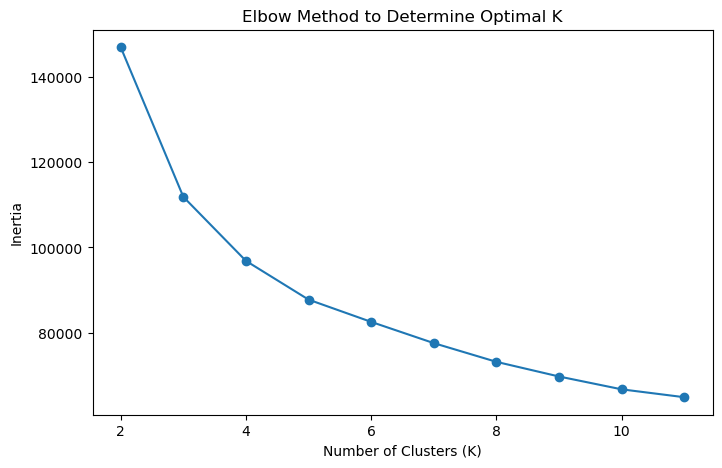

In [50]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Find Optimal Clusters using Elbow Method
inertia = []
K_range = range(2, 12)  # Testing clusters from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method to Determine Optimal K")
plt.show()

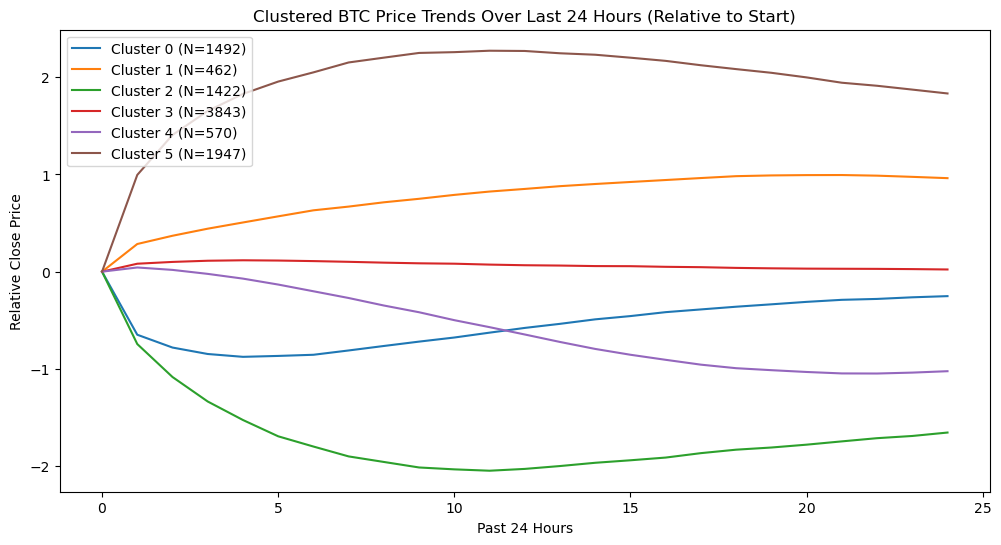

In [59]:
# Step 4: Apply KMeans with Optimal K
optimal_k = 6  # Choose based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=100, n_init=10)
X_df = pd.DataFrame(X_scaled)
X_df['cluster'] = kmeans.fit_predict(X_scaled)

# Step 5: Analyze Cluster Trends
grouped = X_df.groupby('cluster').mean()
cluster_counts = feature_df['cluster'].value_counts().sort_index()

# Step 6: Visualize Each Cluster’s Trend
plt.figure(figsize=(12, 6))

for cluster in grouped.index:
    cluster_size = cluster_counts[cluster]
    plt.plot(grouped.loc[cluster].values, label=f"Cluster {cluster} (N={cluster_size})")

plt.xlabel("Past 24 Hours")
plt.ylabel("Relative Close Price")
plt.title("Clustered BTC Price Trends Over Last 24 Hours (Relative to Start)")
plt.legend()
plt.show()